Question - This case requires trainees to develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan. Data for the case is available in CSV format having 6362620 rows and 10 columns.

The idea is to use 3 different types of classifiers and choose the best one among them. Prepossing of data and undersampling techniques have been applied since the given dataset is highly imbalanced.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import imblearn
from imblearn.under_sampling import NearMiss

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#since the dataset contains float values this function formats each floating-point number to have three decimal places.

Understanding and visualizig data

In [3]:
df = pd.read_csv('Fraud.csv')
df.shape
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4612824 entries, 0 to 4612823
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 387.1+ MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    1
dtype: int64

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0.000
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0.000
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0.000
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0.000
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0.000


In [5]:
df[df.duplicated()]  #no duplicate values found

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


In [6]:
df.drop(columns=['nameOrig','nameDest'],inplace=True)

Plots of all columns to understand variation of data better.

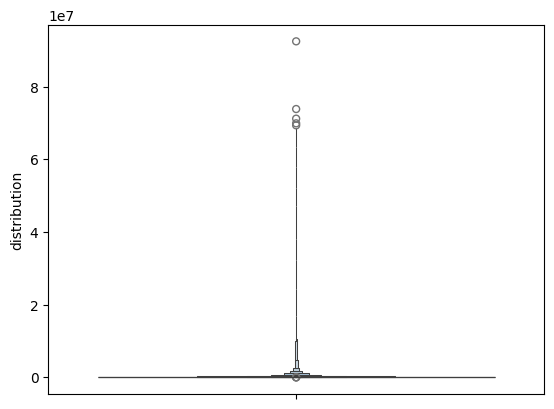

In [7]:
sns.boxenplot(df['amount'])
plt.ylabel('distribution')
plt.rcParams['figure.figsize'] = [2, 2]
plt.show()


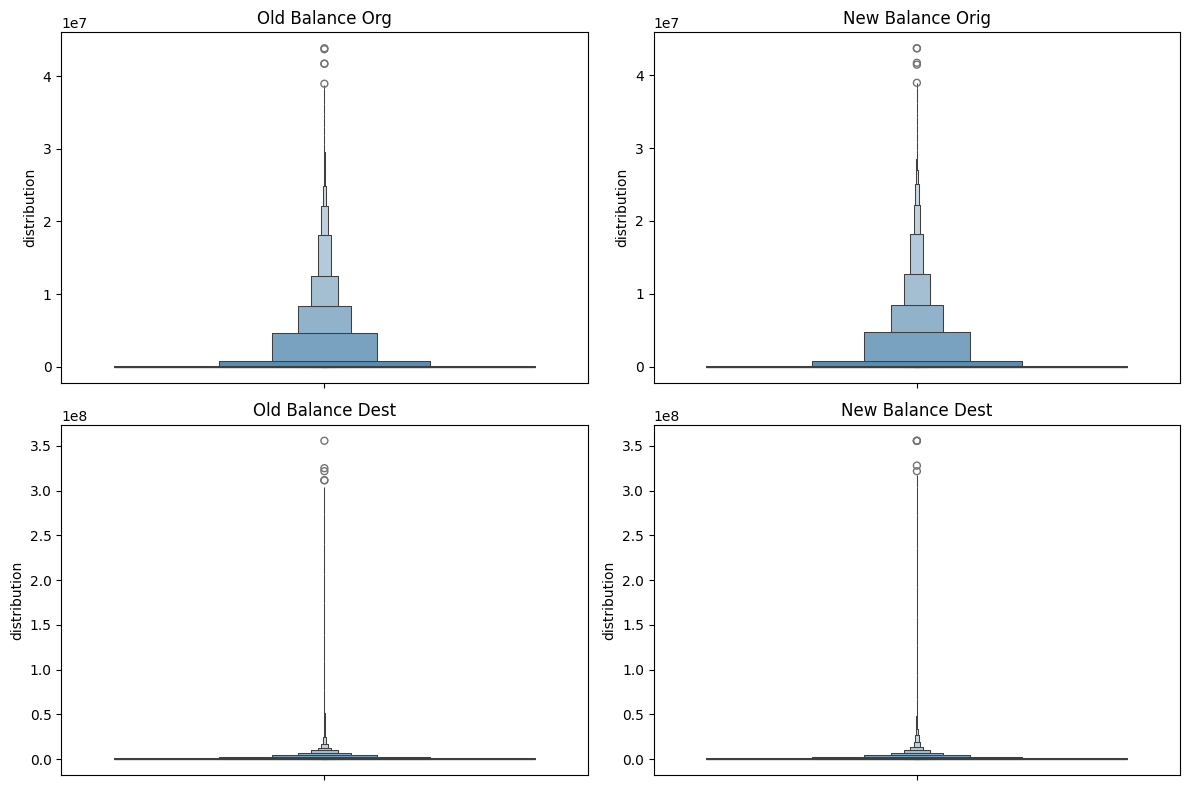

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.boxenplot(df['oldbalanceOrg'], ax=axs[0, 0])
axs[0, 0].set_ylabel('distribution')
axs[0, 0].set_title('Old Balance Org')

sns.boxenplot(df['newbalanceOrig'], ax=axs[0, 1])
axs[0, 1].set_ylabel('distribution')
axs[0, 1].set_title('New Balance Orig')

sns.boxenplot(df['oldbalanceDest'], ax=axs[1, 0])
axs[1, 0].set_ylabel('distribution')
axs[1, 0].set_title('Old Balance Dest')

sns.boxenplot(df['newbalanceDest'], ax=axs[1, 1])
axs[1, 1].set_ylabel('distribution')
axs[1, 1].set_title('New Balance Dest')

plt.tight_layout()
plt.show()

Removing outliers


In [9]:
def remove_outliers(df,col):
    lower_quantile = df[col].quantile(0.25)
    upper_quantile = df[col].quantile(0.75)
    IQR = upper_quantile - lower_quantile
    lower_whisker = lower_quantile - 1.5 * IQR
    upper_whisker = upper_quantile + 1.5 * IQR
    temp = df.loc[(df[col]>lower_whisker)&(df[col]<upper_whisker)]
    return temp[col]
    #calculates the inter quartile range and removes any datapoint below/above the whiskers (considered as outlier)

In [10]:
df['amount'] = remove_outliers(df,'amount')
df['oldbalanceOrg'] = remove_outliers(df,'oldbalanceOrg')
df['newbalanceOrig'] = remove_outliers(df,'newbalanceOrig')
df['oldbalanceDest'] = remove_outliers(df,'oldbalanceDest')
df['newbalanceDest'] = remove_outliers(df,'newbalanceDest')

<Axes: >

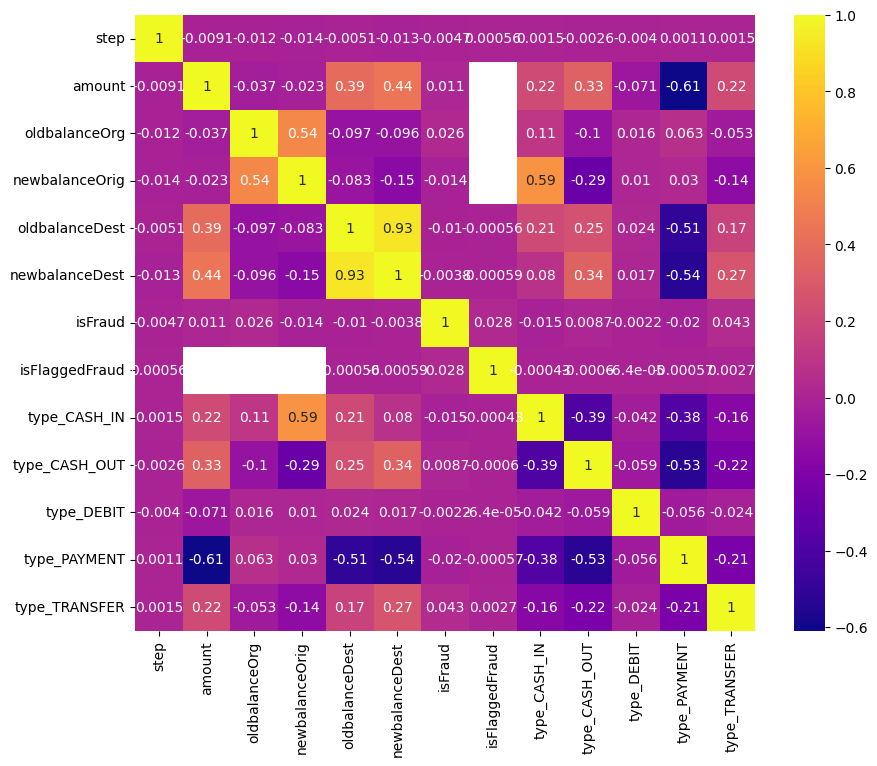

In [11]:
df_encoded = pd.get_dummies(df)
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='plasma')

#The only noteworthy thing from the heatmap is that the transaction recipient's old and new balances are strongly positively correlated with each other.

In [12]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,170136.000,160296.360,0.000,0.000,0,0.000
1,1,PAYMENT,1864.280,21249.000,19384.720,0.000,0.000,0,0.000
2,1,TRANSFER,181.000,181.000,0.000,0.000,0.000,1,0.000
3,1,CASH_OUT,181.000,181.000,0.000,21182.000,0.000,1,0.000
4,1,PAYMENT,11668.140,41554.000,29885.860,0.000,0.000,0,0.000


In [13]:
df.groupby('isFraud').describe()

step                                                       \
              count    mean    std   min     25%     50%     75%     max   
isFraud                                                                    
0       4609119.000 178.988 98.250 1.000 131.000 188.000 257.000 329.000   
1          3705.000 162.855 95.657 1.000  75.000 161.000 247.000 328.000   

             amount             ... newbalanceDest             isFlaggedFraud  \
              count       mean  ...            75%         max          count   
isFraud                         ...                                             
0       4370378.000 112161.948  ...     676163.630 2795411.700    4609118.000   
1          2018.000 172087.489  ...     462339.330 2790375.440       3705.000   

                                                   
         mean   std   min   25%   50%   75%   max  
isFraud                                            
0       0.000 0.000 0.000 0.000 0.000 0.000 0.000  
1       0.001 0.028 0.000 0.000 0.000 0.000 1.000  

[2 rows x 56 columns]

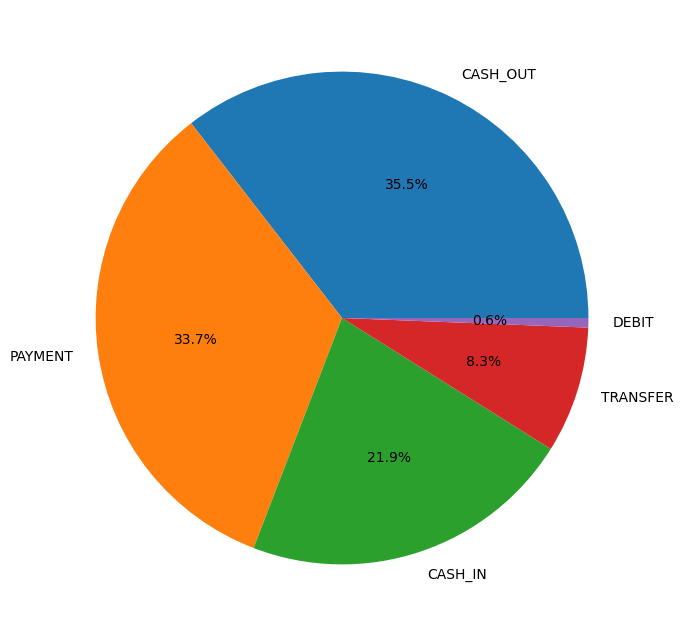

In [14]:
plt.figure(figsize=(8, 8))
values = df['type'].value_counts().values
labels = df['type'].value_counts().keys()
plt.pie(values,labels=labels,autopct='%1.1f%%')
plt.show()

Most of the transactions fall under the category of CASH_OUT, making up just over a third of all transactions. Following closely behind is the Payment mode, which represents nearly 34% of the total transactions. CASH_IN transactions account for just over a fifth of the total, while debit and normal transfer transactions make up a small fraction, each comprising less than one-tenth of all transactions

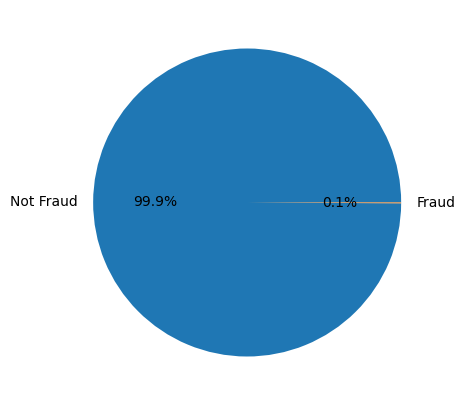

In [15]:
plt.figure(figsize=(5, 5))
values = df['isFraud'].value_counts().values
labels = ['Not Fraud','Fraud']
plt.pie(values,labels=labels,autopct='%1.1f%%')
plt.show()

Just a tiny fraction of the total transactions in the given dataset are fraud which indicates that this is a highly imbalanced dataset

In [16]:

max_amount_type = df.groupby('type')['amount'].max().sort_values(ascending=False).reset_index()[:10]
max_amount_type


,type,amount
0,TRANSFER,503939.320
1,CASH_IN,503938.710
2,CASH_OUT,503938.680
3,DEBIT,417825.070
4,PAYMENT,197201.170


<Axes: xlabel='type', ylabel='amount'>

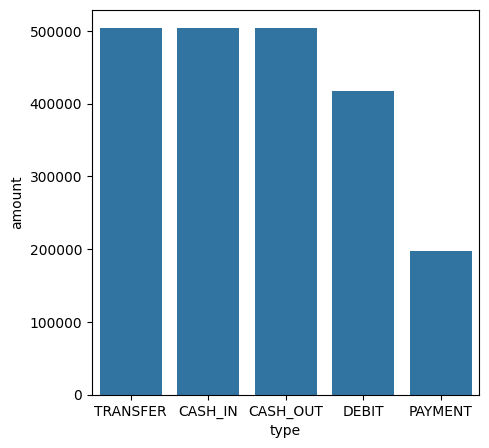

In [18]:
plt.figure(figsize=(5, 5))
sns.barplot(x='type',y='amount',data=max_amount_type)

<ipython-input-19-182a70747d0f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['amount'],bins=50)


<Axes: xlabel='amount', ylabel='Density'>

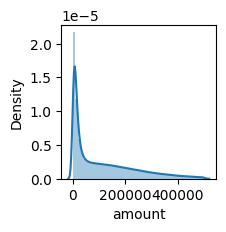

In [19]:
sns.distplot(df['amount'],bins=50)


<ipython-input-21-d7858236d1fe>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(positive_fraud_case['amount'],bins=50)
<ipython-input-21-d7858236d1fe>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(non_fraud_case['amount'],bins=50)


<Axes: xlabel='amount', ylabel='Density'>

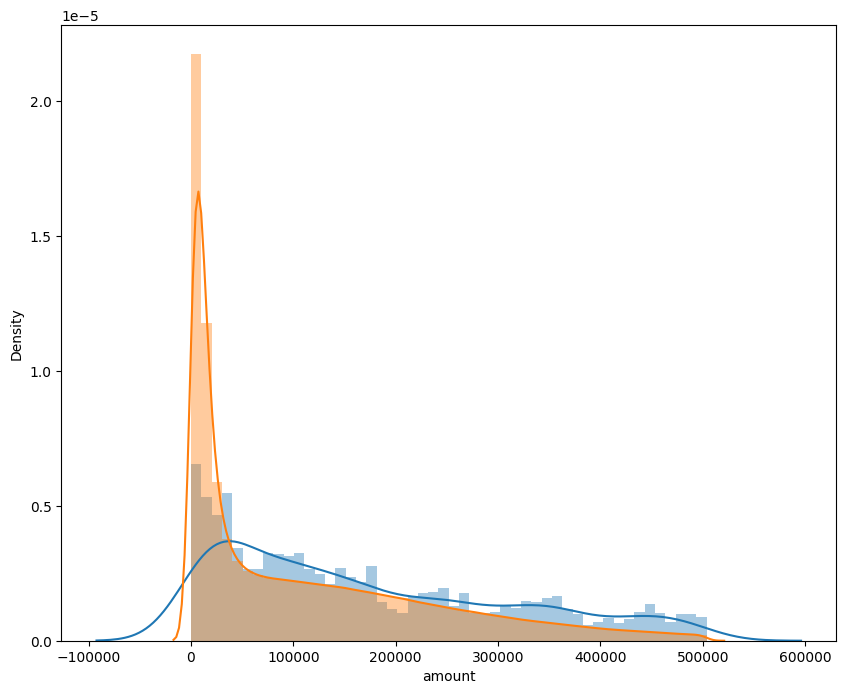

In [21]:
plt.figure(figsize=(10, 8))
positive_fraud_case = df[df['isFraud']==1]
sns.distplot(positive_fraud_case['amount'],bins=50)

non_fraud_case = df[df['isFraud']==0]
sns.distplot(non_fraud_case['amount'],bins=50)

<Axes: xlabel='oldbalanceDest', ylabel='newbalanceDest'>

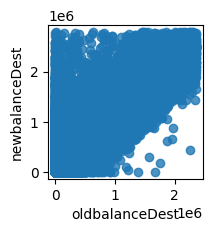

In [22]:
sns.regplot(x='oldbalanceDest',y='newbalanceDest',data=df.sample(100000))

In [23]:
#Performing Min Max Normalization of the features


df['amount'].fillna(df['amount'].mean(),inplace=True)
df['oldbalanceOrg'].fillna(df['oldbalanceOrg'].mean(),inplace=True)
df['newbalanceOrig'].fillna(df['newbalanceOrig'].mean(),inplace=True)
df['oldbalanceDest'].fillna(df['oldbalanceDest'].mean(),inplace=True)
df['newbalanceDest'].fillna(df['newbalanceDest'].mean(),inplace=True)


encoding catergorical values

In [24]:
payment_types = pd.get_dummies(df['type'],prefix='type',drop_first=True)
df = pd.concat([df,payment_types],axis=1)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,PAYMENT,9839.640,170136.000,160296.360,0.000,0.000,0,0.000,False,False,True,False
1,1,PAYMENT,1864.280,21249.000,19384.720,0.000,0.000,0,0.000,False,False,True,False
2,1,TRANSFER,181.000,181.000,0.000,0.000,0.000,1,0.000,False,False,False,True
3,1,CASH_OUT,181.000,181.000,0.000,21182.000,0.000,1,0.000,True,False,False,False
4,1,PAYMENT,11668.140,41554.000,29885.860,0.000,0.000,0,0.000,False,False,True,False


In [25]:
df.drop('type',axis=1,inplace=True)

In [26]:
df['type_CASH_OUT'] = df['type_CASH_OUT'].astype(np.int64)
df['type_DEBIT'] = df['type_DEBIT'].astype(np.int64)
df['type_PAYMENT'] = df['type_PAYMENT'].astype(np.int64)
df['type_TRANSFER'] = df['type_TRANSFER'].astype(np.int64)

The target variable of our machine learning models is predominantly imbalanced which may hamper the predictive accuracy of the models as the predictions may be solely made on the basis of the 'majority class', thereby completely neglecting the 'minority class' as a consequence.

In [27]:
x = df.drop('isFraud',axis=1)
y = df['isFraud']

In [30]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
x_imputed = imputer.fit_transform(x)
nm = NearMiss()
x_nm, y_nm = nm.fit_resample(x_imputed, y) #undersampling

Model Training and Evaluation


In [31]:
X = x_nm
y = y_nm
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.35,stratify=y,random_state=2022)

In [32]:
#Min-Max scaling ensures that all features have the same scale, preventing features
#with larger magnitudes from dominating the model's decision-making process and potentially leading to biased results.
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

# New section
Using random forest classifier


In [33]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [35]:
rfc_pred = rfc.predict(X_test)
rfc_pred

array([1, 1, 0, ..., 0, 1, 0])

In [36]:
print("Confusion Matrix:\n",confusion_matrix(y_test,rfc_pred))
print("Classification Report:\n",classification_report(y_test,rfc_pred))
print("ROC AUC Score:",roc_auc_score(y_test,rfc_pred))
print("F1 Score:",f1_score(y_test,rfc_pred))
print('Accuracy Score:',accuracy_score(y_test,rfc_pred))

Confusion Matrix:
 [[1202   95]
 [   5 1292]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96      1297
           1       0.93      1.00      0.96      1297

    accuracy                           0.96      2594
   macro avg       0.96      0.96      0.96      2594
weighted avg       0.96      0.96      0.96      2594

ROC AUC Score: 0.9614494988434851
F1 Score: 0.96274217585693
Accuracy Score: 0.961449498843485


Using XGboost

In [37]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [38]:
xgb_pred = xgb.predict(X_test)
xgb_pred

array([1, 1, 0, ..., 0, 1, 0])

In [39]:
print("ROC AUC Score:",roc_auc_score(y_test,xgb_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,xgb_pred))
print("F1 Score:",f1_score(y_test,xgb_pred))
print("Classification Report:\n",classification_report(y_test,xgb_pred))
print("Accuracy Score:",accuracy_score(y_test,xgb_pred))

ROC AUC Score: 0.9633770239013107
Confusion Matrix:
 [[1202   95]
 [   0 1297]]
F1 Score: 0.9646708813685385
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.96      1297
           1       0.93      1.00      0.96      1297

    accuracy                           0.96      2594
   macro avg       0.97      0.96      0.96      2594
weighted avg       0.97      0.96      0.96      2594

Accuracy Score: 0.9633770239013107


 Hyperparameter Tuning using GridSearchCV for svm classifier

In [40]:
param_grid = {'C': [1,10,100,1000,10000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}


In [41]:
grid_search_svm = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)
grid_search_svm.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.966 total time=   0.2s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.973 total time=   0.4s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.963 total time=   0.4s
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.960 total time=   0.4s
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.960 total time=   0.4s
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.966 total time=   1.2s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.973 total time=   1.2s
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.963 total time=   1.3s
[CV 4/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.960 total time=   0.8s
[CV 5/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.960 total time=   1.1s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.771 total time=   0.7s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [42]:
grid_search_svm.best_estimator_

SVC(C=10000, gamma=1)

In [43]:
svm = SVC(C=10000,gamma=1)
svm.fit(X_train,y_train)

SVC(C=10000, gamma=1)

In [44]:
svm_pred = svm.predict(X_test)
svm_pred

array([1, 1, 0, ..., 0, 1, 0])

In [45]:
print("ROC AUC Score:",roc_auc_score(y_test,svm_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,svm_pred))
print("F1 Score:",f1_score(y_test,svm_pred))
print("Classification Report:\n",classification_report(y_test,svm_pred))
print("Accuracy Score:",accuracy_score(y_test,svm_pred))


ROC AUC Score: 0.979568234387047
Confusion Matrix:
 [[1280   17]
 [  36 1261]]
F1 Score: 0.9794174757281553
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1297
           1       0.99      0.97      0.98      1297

    accuracy                           0.98      2594
   macro avg       0.98      0.98      0.98      2594
weighted avg       0.98      0.98      0.98      2594

Accuracy Score: 0.979568234387047


In [46]:
print("Performance of ML Models:")
print('Predictive Accuracy of Random Forest Classifier:',str(np.round(accuracy_score(y_test,rfc_pred)*100,2)) + '%')
print('Predictive Accuracy of XGBoost Classifier:',str(np.round(accuracy_score(y_test,xgb_pred)*100,2)) + '%')


Performance of ML Models:
Predictive Accuracy of Random Forest Classifier: 96.14%
Predictive Accuracy of XGBoost Classifier: 96.34%


Random forest Classifier is the best performing model with a prediction accuracy of approximately 96%.

Performing knn neighbours

In [47]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)
knn_pred

array([1, 1, 0, ..., 0, 1, 0])

In [48]:
print("ROC AUC Score:",roc_auc_score(y_test,knn_pred))
print("Confusion Matrix:\n",confusion_matrix(y_test,knn_pred))
print("F1 Score:",f1_score(y_test,knn_pred))
print("Classification Report:\n",classification_report(y_test,knn_pred))
print("Accuracy Score:",accuracy_score(y_test,knn_pred))


ROC AUC Score: 0.9861218195836547
Confusion Matrix:
 [[1292    5]
 [  31 1266]]
F1 Score: 0.9859813084112149
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1297
           1       1.00      0.98      0.99      1297

    accuracy                           0.99      2594
   macro avg       0.99      0.99      0.99      2594
weighted avg       0.99      0.99      0.99      2594

Accuracy Score: 0.9861218195836546


In [49]:
print('Predictive Accuracy of K Neighbors Classifier:',str(np.round(accuracy_score(y_test,knn_pred)*100,2)) + '%')

Predictive Accuracy of K Neighbors Classifier: 98.61%


K Nearest Neighbors Classifier is the best performing model with a prediction accuracy of approximately 98%.

**ANSWERS TO THE QUESTIONS-**

Data Cleaning: Used the Interquartile Range method to remove outliers.

Fraud Detection Model Description: The model utilizes various machine learning algorithms such as Random Forest, K-Nearest Neighbors (KNN), XGBoost, Support Vector Machine (SVM), and Gaussian Naive Bayes.  The models are evaluated based on metrics like accuracy, ROC AUC score, F1 score, and confusion matrix.

Variable Selection: all availables features in have been included in the model. Nameor and Name Dest have been dropped as they are of no importance to the detection

Performance Evaluation: Evaluated using ROC AUC score, F1 score, confusion matrix, and classification report.

Key Predictive Factors for Fraudulent Customers: The key factors predicting fraudulent transactions can be identified through feature importance analysis from models like Random Forest or XGBoost.

Interpretation of Predictive Factors: Yes, the predictive factors make sense. For example, fraudulent transactions may involve unusually large amounts, certain types of transactions (e.g., transfers rather than payments), or abnormal behavior in account balances.

Preventive Measures for Infrastructure Update: Prevention measures could include enhancing authentication methods (e.g., multi-factor authentication), implementing anomaly detection algorithms to flag suspicious transactions, conducting regular audits, and providing fraud awareness training for employees and customers.

Evaluation of Prevention Measures: The effectiveness of prevention measures can be assessed by comparing key metrics before and after implementation. For example, comparing the number of detected fraudulent transactions, false positive rates, and overall customer satisfaction. Additionally, you can conduct A/B testing to evaluate the impact of specific measures on fraud detection performance.